## Modelo de Identificación de Alta Conductividad en Canal Condensados DUPLEX

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '5'

import numpy as np
import pandas as pd
import seaborn as sns
import funciones
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

In [2]:
# Carga del Dataset
df_raw = pd.read_csv('Canal_Condensados_DUPLEX.csv')

# Imputación de Medias por Día para Valores faltantes o con Error
df_raw = funciones.imputacion_media_dia(df_raw,False)

# Nombre de Variable Objetivo
canal = "Conductividad agua condensados Duplex (uS)"

df_raw

,Dia Zafra,Nivel Vaso B1 (%),Nivel Vaso B1 (%)_STD,Nivel Vaso B2 (%),Nivel Vaso B2 (%)_STD,Nivel Vaso B3 (%),Nivel Vaso B3 (%)_STD,Nivel Vaso B4 (%),Nivel Vaso B4 (%)_STD,Nivel Vaso B5 (%),Nivel Vaso B5 (%)_STD,Nivel Vaso B6 (%),Nivel Vaso B6 (%)_STD,Nivel Vaso B7 (%),Nivel Vaso B7 (%)_STD,Nivel Vaso B8 (%),Nivel Vaso B8 (%)_STD,Nivel Vaso B9 (%),Nivel Vaso B9 (%)_STD,Conductividad agua condensados Duplex (uS)
0,1.0,99.959401,0.027289,0.177978,0.199749,0.000000,0.000000,4.727166,0.050470,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.324171,0.128622,0.386238,0.117805,15.000000
1,1.0,99.957494,0.027788,0.204413,0.204897,0.000000,0.000000,4.720686,0.050326,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.320169,0.140214,0.591648,0.020875,15.000000
2,1.0,99.958111,0.028743,0.236062,0.213011,0.000000,0.000000,4.723700,0.049141,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.323735,0.123068,0.560969,0.041870,15.000000
3,1.0,99.959080,0.026746,0.219940,0.214069,0.000000,0.000000,4.719239,0.051018,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.310855,0.131447,0.584514,0.016998,15.000000
4,1.0,99.964268,0.025305,0.224809,0.213275,0.000000,0.000000,4.718115,0.052965,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.312177,0.125373,0.585065,0.014594,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,50.0,42.661980,8.511949,19.917497,7.306967,100.000000,0.000000,34.381441,10.509983,25.780031,8.997945,29.946342,11.844981,34.821309,8.548488,30.726506,7.764387,53.669241,6.759222,127.413257
1183,50.0,39.624565,5.425194,20.128517,3.066848,100.000000,0.000000,29.091782,1.997909,21.062088,4.618067,16.173180,2.630650,33.033647,2.288662,33.634611,2.508717,49.210157,3.126777,125.895645
1184,50.0,44.796310,4.363164,15.082397,1.964211,79.173119,34.564811,28.436441,0.960506,16.958544,1.215842,14.617890,0.388806,32.695789,2.752030,37.871430,1.777041,49.568861,0.615361,124.694441
1185,50.0,44.612901,15.461499,23.304160,7.451659,53.967443,41.904018,29.034270,6.751500,21.726450,6.840580,17.235134,4.983570,32.815724,9.668283,32.085336,10.896007,50.393540,10.421798,120.356678


### Tratamiento de Outliers y Distribución de Frecuencias de Valores de Conductividad

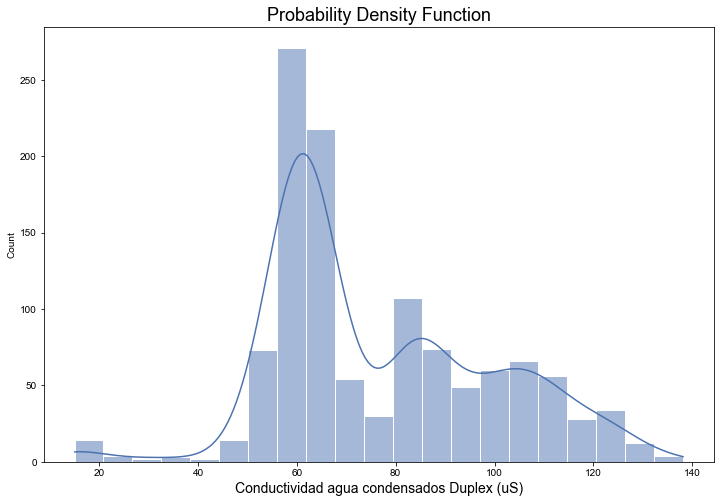

 Estadísticas de Conductividad: 


count    1175.000000
mean       76.757198
std        22.604305
min        15.000000
25%        60.413321
50%        67.200366
75%        92.713168
max       138.187840
Name: Conductividad agua condensados Duplex (uS), dtype: float64

In [3]:
df = funciones.outliers(df_raw,canal,1)

### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de conductividad. La binarización consiste en *transformar* la variable continua de conductividad a una variable binaria de *presencia* o *no presencia* de conductividad. Esto porque no toda conductividad se debe necesariamente a trazas de azúcar, y en la práctica es más útil definir un límite superior para esta variable. 

La binarización se implementa de forma que: Una **alta conductividad es una clase POSITIVA** y una **baja conductividad es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de conductividad, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de conductividad.

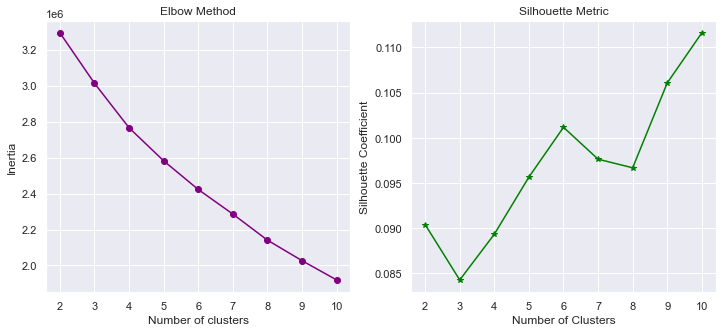

In [4]:
funciones.exploracion_clusters(df,canal)

Puede observarse que **las métricas de cohesión son más altas para 6 agrupaciones**. Se forman los 6 grupos utilizando el algoritmo K-Means, con n=6. Luego, se grafica la serie de tiempo de la conductividad durante la zafra y se colorean las regiones encontradas.

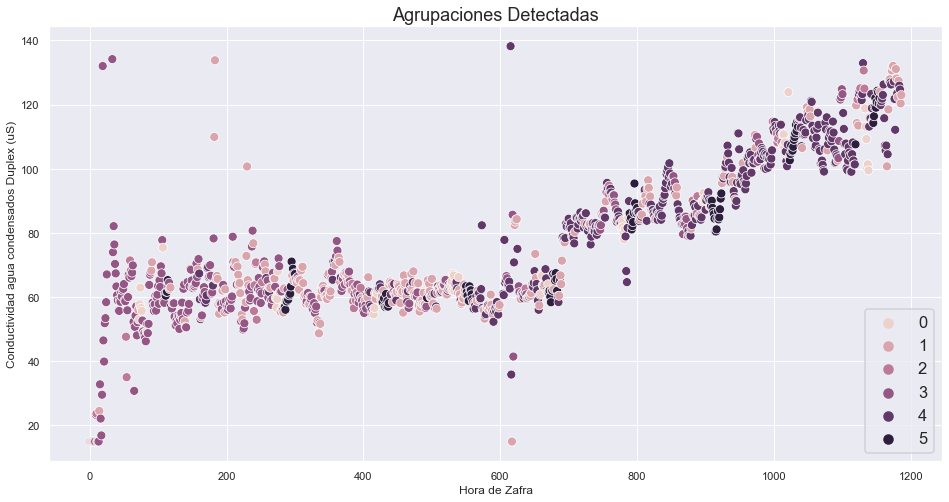

 Medias por Agrupación: 


,Dia Zafra,Nivel Vaso B1 (%),Nivel Vaso B1 (%)_STD,Nivel Vaso B2 (%),Nivel Vaso B2 (%)_STD,Nivel Vaso B3 (%),Nivel Vaso B3 (%)_STD,Nivel Vaso B4 (%),Nivel Vaso B4 (%)_STD,Nivel Vaso B5 (%),Nivel Vaso B5 (%)_STD,Nivel Vaso B6 (%),Nivel Vaso B6 (%)_STD,Nivel Vaso B7 (%),Nivel Vaso B7 (%)_STD,Nivel Vaso B8 (%),Nivel Vaso B8 (%)_STD,Nivel Vaso B9 (%),Nivel Vaso B9 (%)_STD,Conductividad agua condensados Duplex (uS)
group,,,,,,,,,,,,,,,,,,,,
0,28.137931,40.924383,5.262988,31.813269,5.033036,23.543226,4.107840,31.966459,4.349059,15.963472,2.581478,63.259837,27.166024,17.148821,3.481279,25.038255,3.201921,37.186845,5.160939,78.350583
1,22.890566,49.841662,13.054646,36.223768,10.187924,34.817752,8.233429,38.073583,8.331329,26.057303,5.350501,15.342114,4.794132,36.113731,7.749406,40.831698,8.907316,41.718969,9.353829,72.399137
2,25.906977,43.202307,4.213827,30.312375,4.137312,19.719085,2.446089,33.334673,3.819871,43.353872,37.226404,13.183805,3.848917,27.509226,4.057061,21.812634,3.489777,31.675481,3.448514,78.435973
3,13.016393,32.084821,3.262500,26.569189,3.482723,14.513827,2.327340,26.522350,3.211641,22.416745,2.363246,9.438810,3.018315,39.373266,5.766031,19.702715,2.753158,24.112211,3.442219,63.050932
4,34.851385,45.361880,4.479375,25.233777,3.661720,31.088025,5.960455,27.603373,2.311886,26.316002,2.705803,12.114988,2.887245,23.087827,2.833370,28.940865,3.453186,37.434804,4.991436,88.884217
5,29.962617,51.354300,4.610102,38.698830,4.593651,30.345470,3.854217,80.634145,15.291702,18.989190,2.819004,12.529373,3.709286,24.521492,3.041072,27.200962,2.745858,36.845199,3.294780,80.086798


 Desviaciones Estándar por Agrupación: 


,Dia Zafra,Nivel Vaso B1 (%),Nivel Vaso B1 (%)_STD,Nivel Vaso B2 (%),Nivel Vaso B2 (%)_STD,Nivel Vaso B3 (%),Nivel Vaso B3 (%)_STD,Nivel Vaso B4 (%),Nivel Vaso B4 (%)_STD,Nivel Vaso B5 (%),Nivel Vaso B5 (%)_STD,Nivel Vaso B6 (%),Nivel Vaso B6 (%)_STD,Nivel Vaso B7 (%),Nivel Vaso B7 (%)_STD,Nivel Vaso B8 (%),Nivel Vaso B8 (%)_STD,Nivel Vaso B9 (%),Nivel Vaso B9 (%)_STD,Conductividad agua condensados Duplex (uS)
group,,,,,,,,,,,,,,,,,,,,
0,13.947833,17.880377,4.643692,8.252034,3.472203,9.773682,3.255171,9.330149,4.266885,3.317304,1.554100,29.309279,16.014782,8.347864,3.902252,12.666182,3.732965,11.018588,4.098295,20.783401
1,11.691720,17.634167,10.854174,18.048334,10.580995,15.759011,7.590566,13.403570,5.607408,13.512889,4.190682,6.882917,3.265752,13.457945,5.961181,15.196113,8.038077,15.984303,7.775988,20.629600
2,14.444992,21.980236,3.130312,8.285685,2.401270,11.350102,2.006238,11.456562,3.410121,17.645427,5.449810,6.059522,3.091305,10.306941,4.221079,10.772692,4.463991,19.000203,2.725322,26.379852
3,11.398136,20.821125,3.413322,15.410124,4.760861,10.263383,3.106178,8.796142,3.595897,21.049567,2.624020,5.932011,3.189678,19.161175,7.283602,13.177540,3.107484,17.538472,6.953003,18.471079
4,9.932885,18.268902,4.450749,17.314212,5.807200,22.262925,10.156518,4.722503,1.864967,18.598677,2.078168,6.101906,1.991349,8.772480,2.663870,12.127605,4.908202,16.315834,7.815245,20.066682
5,12.598237,11.144677,2.922617,7.589344,3.256106,8.930982,2.635614,21.270689,15.047341,8.372411,2.514939,4.982062,3.248414,8.037123,1.799101,9.305046,2.008475,10.864750,2.372162,21.348754


In [5]:
funciones.clustering(df,canal,6)

Puede observarse que las agrupaciones 0 y 1 comparten tendencias de conductividad bajas. Existe un valor de aproximadamente 250 a 300 uS de conductividad en estas regiones estables.

Para explorar este umbral de conductividad, se implementa un algoritmo que explora *distintos umbrales de conductividad* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad de Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,Overall
Umbral Conductividad,,,,,
60.0,0.760115,0.787535,0.871355,0.927007,0.836503
70.0,0.916863,0.915014,0.910714,0.879310,0.905475
80.0,0.957552,0.957507,0.951768,0.954839,0.955416
100.0,0.955221,0.954674,0.890411,0.902778,0.925771
110.0,0.896191,0.909348,0.466667,0.358974,0.657795


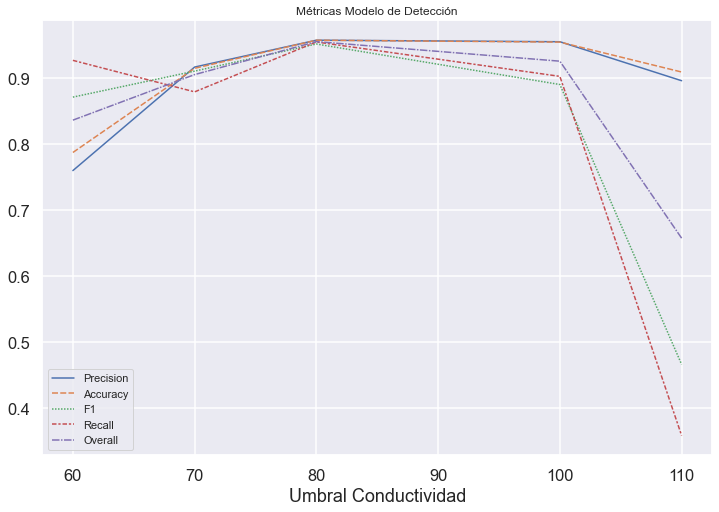

In [6]:
funciones.busqueda_umbral(df,canal,[60,70,80,100,110])

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 25 nos proporciona suficiente rango y además las métricas están arriba del 80%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [7]:
# Umbral de Detección
umbral_final = 80

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop(canal, axis=1)
y = df[canal].apply(lambda x: 1 if x > umbral_final else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [8]:
# Estandarización y Entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
coefficients = model.coef_[0]

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

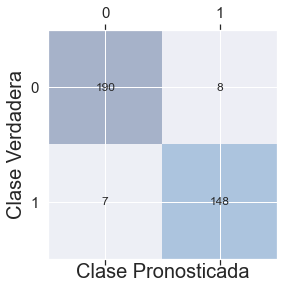

In [9]:
y_pred = model.predict(X_test_scaled)

conf_mat = funciones.matriz_confusion(y_test,y_pred)

In [10]:
funciones.metricas_finales(y_test,y_pred,umbral_final)

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),Overall (%)
0,80.0,95.75517,95.750708,95.176849,95.483871,95.541649


### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la conductividad.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta conductividad).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta conductividad).

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la conductividad final**.

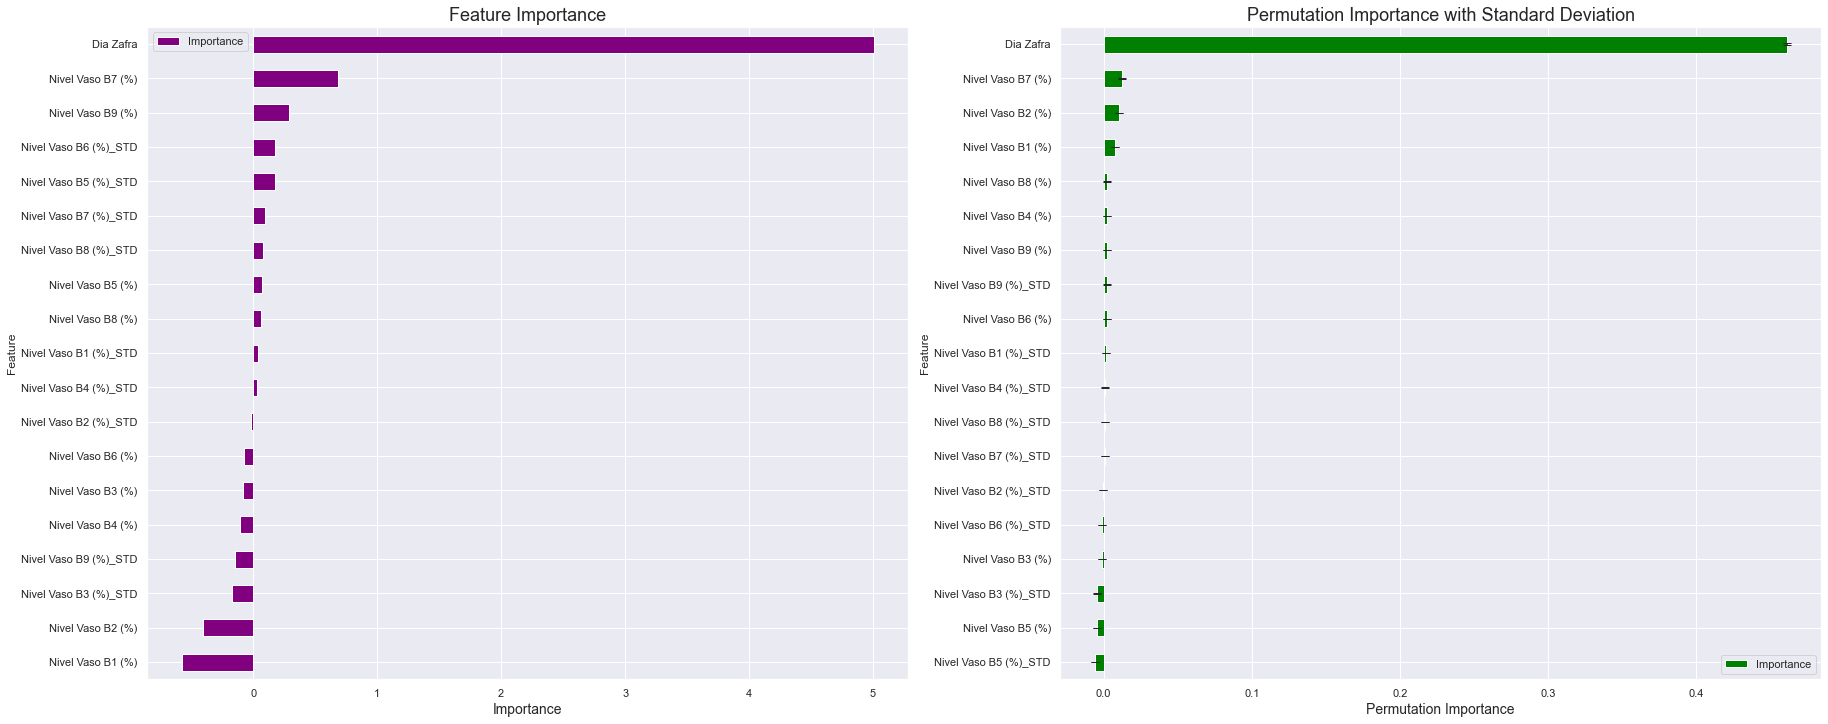

In [11]:
funciones.importancias_modelo(model,X,coefficients,X_test_scaled,y_test)

### Probabilidad de Clase Positiva (Alta Conductividad)
El modelo permite conocer cómo cada factor impacta la probabilidad de obtener la **clase positiva** (*alta conductividad*). 

Para ello se presentan los **incrementos en probabilidad**: *Si el factor tiene un incremento unitario, cuánto aumenta la probabilidad de tener una alta conductividad*.

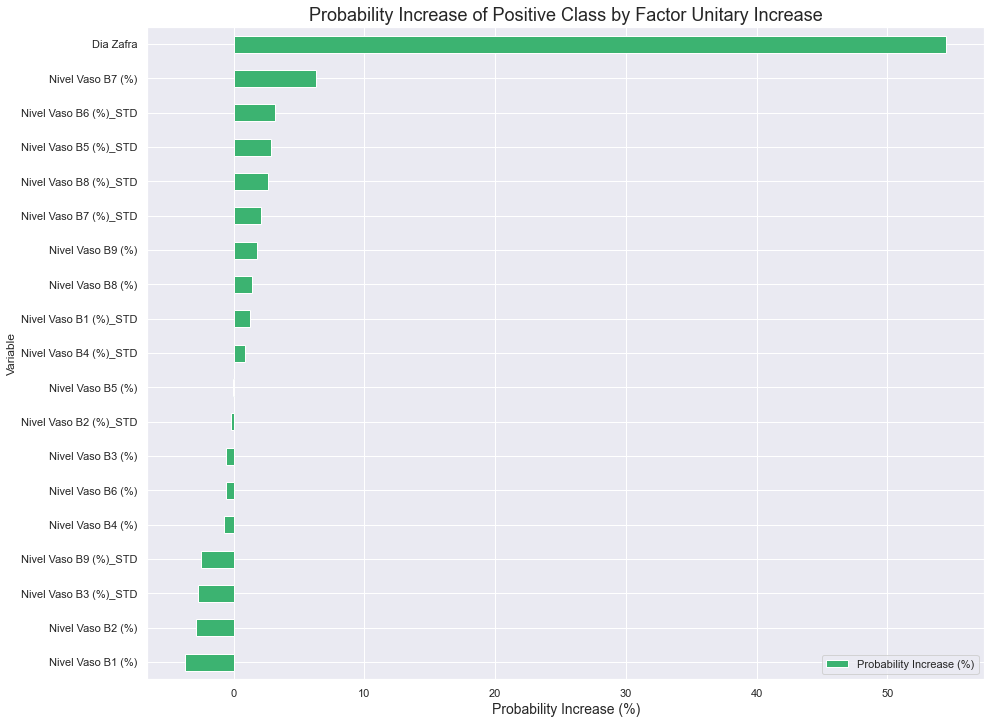

In [12]:
funciones.logprob(X,X_train,y_train)

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son las siguientes:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la probabilidad de tener alta conductividad*.
- Para conocer *qué tanto incrementar o decrementar el SP del factor*, se verifica su contribución a la **Probabilidad de Clase Positiva**: Si la contribución es positiva, se recomienda reducir el SP. Si la contribución es negativa, se recomienda aumentar el SP. Ambas acciones **reducirán la probabilidad de ocurrencia de la clase positiva** (alta conductividad).
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la estabilidad de la conductividad*.